# Summary

This notebook aims to explore sampling from the branching process Y.
It is a prerequisite for running experiments that explore relationships
relevant for the paper, for example:
* "goodness of fit" as a function of noise,
* "goodness of fit" as a function of output dimensions,
* overall sanity checks of "can we fit the model to itself?".

In [1]:
from MMBGP.data_generation import ToyBranchedData, GeneExpressionData
from MMBGP.training_helpers import TrainingOutcome, get_training_outcome
from MMBGP.plotting_helpers import plot_detailed_fit, plot_model_snapshot
from MMBGP.assigngp import AssignGP
from MMBGP.VBHelperFunctions import plotBranchModel
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from MMBGP.training_helpers import (
    construct_assigngp_model, 
    SimplePhiConstructor, 
    ScipyOptimiser, 
    ElvijsAmazingOptimiser,
)
import gpflow


data = ToyBranchedData([0.1, 0.3, 0.5], N=100)  # not used; need data to construct a model
m = construct_assigngp_model(
    gene_expression=data,  
    phi_constructor=SimplePhiConstructor(data, prior_confidence=0.65),
    initial_branching_points=[0.5]*data.num_genes,
)
# assign reasonable initial values for the BPs and vi
m.kernel.Bv.assign(np.array([0.1, 0.3, 0.5]))
m.likelihood

name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Softplus + Shift,,True,(),float64,1


In [5]:
from MMBGP.VBHelperFunctions import GetFunctionIndexListGeneral

x_new = np.linspace(0, 1, 50)
x_expanded, indices, _ = GetFunctionIndexListGeneral(x_new)

samples = m.sample_prior(x_expanded, num_samples=1)
print(samples.shape)
print(x_expanded.shape)

(1, 150, 3)
(150, 2)


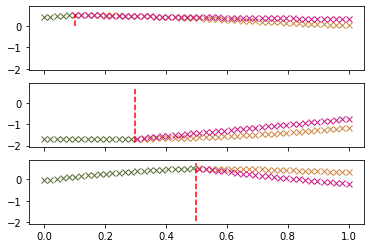

In [6]:
from MMBGP.plotting_helpers import plot_samples

plot_samples(x_expanded, samples, m.BranchingPoints)
plt.show()

OK, that looks pretty reasonable. 
Let's now look at samples in GeneExpressionData format. 

(<Figure size 648x216 with 3 Axes>,
 array([<AxesSubplot:title={'center':'gene 0'}>,
        <AxesSubplot:title={'center':'gene 1'}>,
        <AxesSubplot:title={'center':'gene 2'}>], dtype=object))

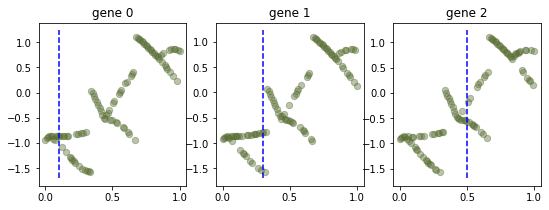

In [7]:
dummy_data = m.sample_prior_as_branched_data()
dummy_data.plot()

Hmm, still doesn't look right - some issues with slicing? 
Let's take the function into here and experiment around.

In [8]:
from MMBGP.data_generation import BranchedData


def sample_prior_as_branched_data(model: AssignGP, num_data_points: int = 100) -> BranchedData:
    """
    Sample from the model's prior (that is, ignore the data).

    Return as BranchedData.
    In particular, this means that function samples are clipped according
    to where the branching points lie.
    """
    N = num_data_points
    D = model.Y.shape[1]

    x_new = np.linspace(0, 1, N)
    x_expanded, _, __ = GetFunctionIndexListGeneral(x_new)  # [3*N, 2]

    samples = model.sample_prior(x_expanded, num_samples=1)  # [1, 3*N, D]
    plot_samples(x_expanded, samples, model.BranchingPoints)  # TODO: remove
    sample = samples.squeeze()  # [3*N, D]

    # The sample above is of f, g, h over the whole of x_new.
    # We now need to produce a sample from the branching process Y.
    # Therefore we need to throw away the trunk (f) bit after the branching point
    # as well as the branches (g and h) before the branching point.
    f_id = 1
    g_id = 2

    min_bp = 1.
    ys = []
    for d in range(D):
        # Due to the construction of x_expanded, we know that
        # if x_expanded[i, 1] == 2, then x_expanded[i+1, 1] == 3 and they correspond to
        # the same time-step described in x_new.
        b = model.BranchingPoints[d]
        
        before_branching_mask = x_expanded[:, 0] < b

        trunk_mask = np.logical_and(x_expanded[:, 1] == f_id, before_branching_mask)
        trunk = sample[trunk_mask, d]  # we take all of the trunk

        # Now let's construct the branches. 
        # Start with indices corresponding to g (after the branching point) and add 1 to every other index 
        branch_mask = np.logical_and(x_expanded[:, 1] == g_id, x_expanded[:, 0] >= b)
        branch_idx = np.where(branch_mask)[0]
        branch_idx[::2] += 1
        sampled_g_and_h = sample[branch_idx, d]

        y_sample = np.row_stack(tuple(
            arr.reshape((-1, 1)) for arr in [trunk, sampled_g_and_h] if arr.size
        ))
        ys.append(y_sample)
        
        if b < min_bp:
            min_bp = b
            
            # Get the branch mask we actually used, including the offsets
            branch_mask = np.zeros(shape=branch_mask.shape, dtype=bool)
            branch_mask[branch_idx] = 1  # convert the indices into a mask
            
            bp_idx = np.where(x_expanded[:, 0] >= b)[0][0]  # assumes x_expanded[:, 0] is ascending
            state_mask = np.concatenate((trunk_mask[:bp_idx], branch_mask[bp_idx:]))

    y = np.column_stack(ys)
    
    # Now add noise
    y += np.sqrt(model.likelihood.variance.numpy()) * np.random.standard_normal(y.shape)

    return BranchedData(
        t=x_new,
        Y=y,
        state=x_expanded[state_mask, 1],
        branching_points=model.BranchingPoints,
        gene_labels=None,
    )

(<Figure size 648x216 with 3 Axes>,
 array([<AxesSubplot:title={'center':'gene 0'}>,
        <AxesSubplot:title={'center':'gene 1'}>,
        <AxesSubplot:title={'center':'gene 2'}>], dtype=object))

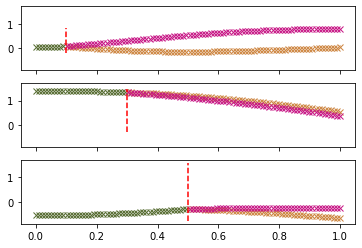

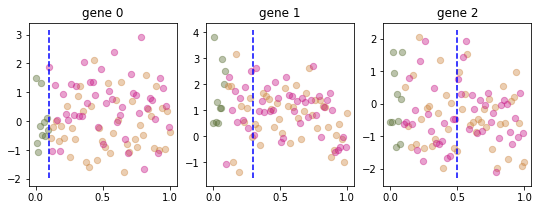

In [9]:
sample_prior_as_branched_data(m).plot()

OK, much better, the cell assignment isn't quite right 
(depending on your random seed, you might have to re-run the cell a few times, 
but what you should see is an inconsistency in branch labeling from f, g, h to Y), 
but at least the noise looks reasonable.

Let's quickly check the noise makes sense.

In [10]:
m.likelihood.variance.numpy()

array(1.)

(<Figure size 648x216 with 3 Axes>,
 array([<AxesSubplot:title={'center':'gene 0'}>,
        <AxesSubplot:title={'center':'gene 1'}>,
        <AxesSubplot:title={'center':'gene 2'}>], dtype=object))

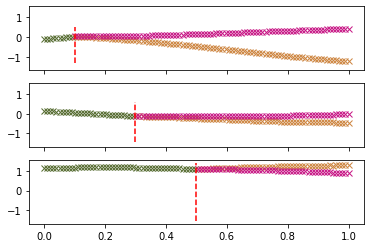

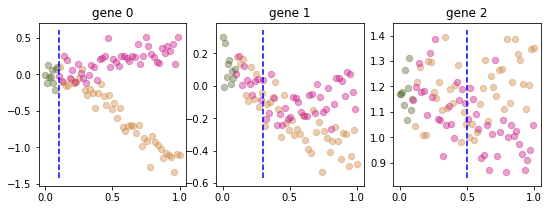

In [16]:
m.likelihood.variance.assign(0.01)
synthetic_noisy_data = sample_prior_as_branched_data(m)
synthetic_noisy_data.plot()

OK, this looks pretty reasonable.

Can we fit a model back to this data?

In [17]:
nm = construct_assigngp_model(
    gene_expression=synthetic_noisy_data,  
    phi_constructor=SimplePhiConstructor(synthetic_noisy_data, prior_confidence=0.65),
    initial_branching_points=[0.5]*synthetic_noisy_data.num_genes,
)
optimiser = ScipyOptimiser()

nm

name,class,transform,prior,trainable,shape,dtype,value
AssignGP.ZExpanded,Parameter,Identity,,False,"(180, 2)",float64,"[[0., 1...."
AssignGP.kernel.kern.variance,Parameter,Softplus,,True,(),float64,1.0
AssignGP.kernel.kern.lengthscales,Parameter,Softplus,,True,(),float64,1.0
AssignGP.kernel.Bv,Parameter,Sigmoid,,True,"(3,)",float64,[0.5 0.5 0.5]
AssignGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
AssignGP.logPhi,Parameter,Identity,,True,"(100, 300)",float64,"[[-20.72326584, -0.98205636, -0.46926809..."


In [18]:
optimiser.train(nm)

nm

name,class,transform,prior,trainable,shape,dtype,value
AssignGP.ZExpanded,Parameter,Identity,,False,"(180, 2)",float64,"[[0., 1...."
AssignGP.kernel.kern.variance,Parameter,Softplus,,True,(),float64,0.31664196310986936
AssignGP.kernel.kern.lengthscales,Parameter,Softplus,,True,(),float64,0.7366743088680634
AssignGP.kernel.Bv,Parameter,Sigmoid,,True,"(3,)",float64,[4.01067963e-46 3.54254927e-06 5.55555601e-01]
AssignGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.010131417081675196
AssignGP.logPhi,Parameter,Identity,,True,"(100, 300)",float64,"[[-20.72326584, -0.98205636, -0.46926809..."


(<Figure size 648x216 with 3 Axes>,
 array([<AxesSubplot:title={'center':'gene 0'}>,
        <AxesSubplot:title={'center':'gene 1'}>,
        <AxesSubplot:title={'center':'gene 2'}>], dtype=object))

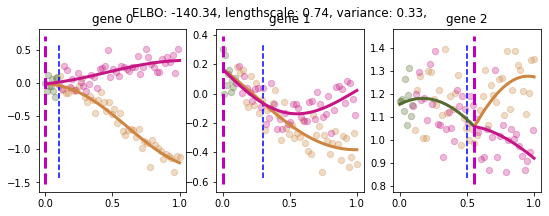

In [21]:
from MMBGP.plotting_helpers import plot_model_snapshot

plot_model_snapshot(nm, synthetic_noisy_data, alpha=0.3)

The fits are consistent with what we've seen before. 
Plenty to improve, but no red flags in the simple implementation.